In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
from pathlib import Path
print(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent))

# Import necessary libraries
import os
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict, Union, Tuple, Optional
from pathlib import Path

# Import custom modules
from Data.data_class import plot_electron_spectrogram
from data_loader import MagnetotailDataset
from MAE_transformer import MAETransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\ianma\OneDrive\Documents\Thesis\Magnetotail-Boundary-with-ML


In [33]:
file_path = Path('..') / "Data" / "training_data" / "test.h5"
abs_file_path = file_path.resolve()

# Create dataset
dataset = MagnetotailDataset(abs_file_path)

In [34]:
# Create a list of cutoff times for training
initial_cutoff_list = ['2011-08-14 22:50:00', 
                       '2011-11-13 03:00:00',
                       '2011-11-13 22:00:00',
                       '2011-08-17 08:00:00',
                       '2011-09-13 17:00:00',
                       '2011-09-14 13:15:00',
                       '2011-09-14 23:00:00',
                       '2012-02-09 11:00:00',
                       '2012-05-03 23:00:00', 
                       '2012-11-30 10:30:00',
                       ]
final_cutoff_list = ['2011-08-15 18:30:00',
                     '2011-11-13 04:30:00',
                     '2011-11-13 23:30:00',
                     '2011-08-17 09:00:00',
                     '2011-09-13 21:00:00',
                     '2011-09-14 14:15:00',
                     '2011-09-15 00:30:00',
                     '2012-02-09 14:00:00',
                     '2012-05-04 07:00:00',
                     '2012-11-30 12:00:00',
                     ]


# Assing the trainable times to the dataset
dataset.exclude_time_ranges(initial_cutoffs=initial_cutoff_list,
                           final_cutoffs=final_cutoff_list
                           )

In [35]:
train_samples = dataset.get_trainable_samples()


In [40]:
# Prepare the training data using trainable indices and 'B_ion_eflux'
trainable_data = dataset.get_trainable_samples()

# Define how many time steps to use for the input
timestamps = 4

# Initialize the autoencoder
autoencoder = MAETransformer(timestamps=timestamps)

In [41]:
prepared_train_data, prepared_test_data  = autoencoder.prepare_data(trainable_data)

In [42]:
autoencoder = autoencoder.fit(prepared_train_data, prepared_test_data, epochs=10, batch_size=64)

Epoch [1/10], Loss: 0.0611, Test Loss: 0.0376
Epoch [2/10], Loss: 0.0348, Test Loss: 0.0330
Epoch [3/10], Loss: 0.0311, Test Loss: 0.0305
Epoch [4/10], Loss: 0.0300, Test Loss: 0.0291
Epoch [5/10], Loss: 0.0288, Test Loss: 0.0277
Epoch [6/10], Loss: 0.0279, Test Loss: 0.0281
Epoch [7/10], Loss: 0.0282, Test Loss: 0.0286
Epoch [8/10], Loss: 0.0271, Test Loss: 0.0271
Epoch [9/10], Loss: 0.0266, Test Loss: 0.0271
Epoch [10/10], Loss: 0.0265, Test Loss: 0.0272


In [43]:
file_path = Path('..') / "Data" / "testing_data" / "test.h5"
abs_file_path = file_path.resolve()

# Create dataset
testing_dataset = MagnetotailDataset(abs_file_path)

In [44]:
testing_data, _ = autoencoder.prepare_data(testing_dataset.get_trainable_samples(), test_fraction=0)

In [47]:
def huber_loss(pred, target, delta=0.2):  # delta is key parameter
    error = torch.abs(pred - target)
    return torch.where(error < delta, 
                      0.5 * error ** 2,      # MSE for small errors
                      delta * (error - 0.5 * delta))  # Linear for large errors

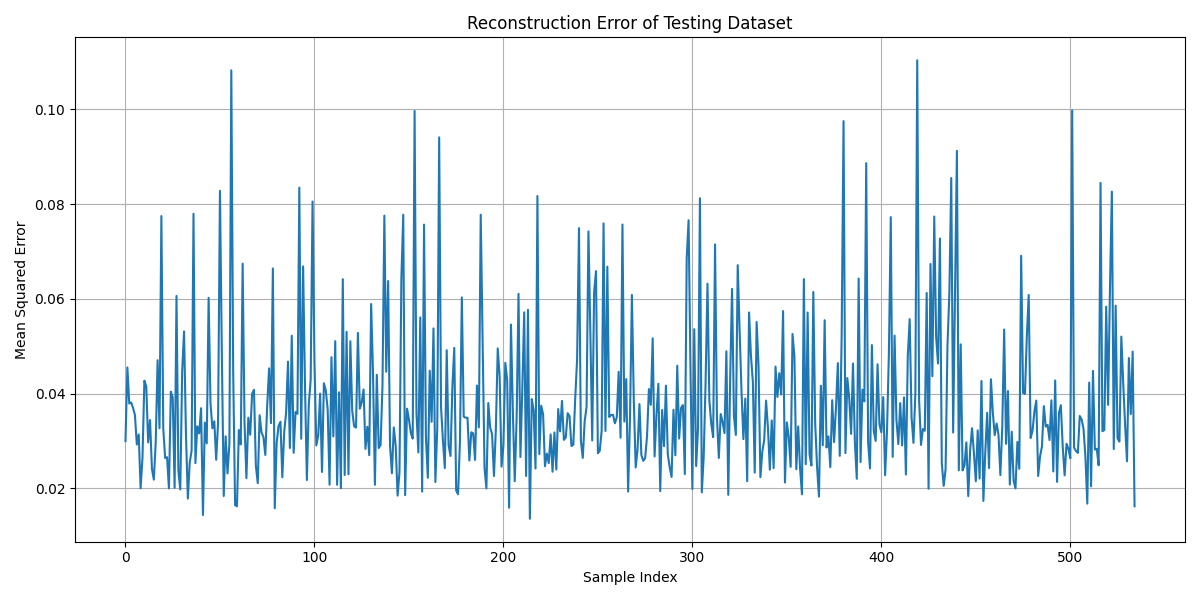

In [49]:
# Get the original and reconstructed data
with torch.no_grad():
    _, reconstructed, _ = autoencoder(testing_data)
    
# Calculate reconstruction error (mean squared error)
reconstruction_error = huber_loss(testing_data, reconstructed).mean(dim=(1, 2))

# Plot the reconstruction error
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(reconstruction_error.cpu().numpy())
plt.title('Reconstruction Error of Testing Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.tight_layout()